# Proyek Klasifikasi Gambar: Shoe vs Sandal vs Boot Dataset
- **Nama:** Naufal Rafly Wanhar
- **Email:** naufalraflywanhar@gmail.com
- **ID Dicoding:** MC006D5Y1410


## Import Semua Packages/Library yang Digunakan

In [ ]:
# Library Umum
import os
import shutil
from shutil import copyfile
from pathlib import Path
import zipfile
import random
from random import sample

# Data dan Visualisasi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tq

# Pemrosesan Gambar
import cv2
from PIL import Image
from skimage import io, img_as_ubyte
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage.util import random_noise, img_as_float, img_as_ubyte

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import (InputLayer, Conv2D, SeparableConv2D, MaxPooling2D,
                                     MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Cek versi TensorFlow
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [ ]:
# Upload file kaggle.json (jika belum ada)
from google.colab import files
uploaded = files.upload()

# Cek apakah file kaggle.json sudah ada
if os.path.exists('kaggle.json'):
    print("✅ File kaggle.json ditemukan.")
else:
    print("❌ File kaggle.json tidak ditemukan. Silakan upload dulu.")

# Install dan setup Kaggle API
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

# Ekstrak dataset
if os.path.exists("shoe-vs-sandal-vs-boot-dataset-15k-images.zip"):
    !unzip -q shoe-vs-sandal-vs-boot-dataset-15k-images.zip
    print("✅ Dataset berhasil diekstrak.")
else:
    print("❌ File ZIP tidak ditemukan.")

Saving kaggle.json to kaggle.json
✅ File kaggle.json ditemukan.
Dataset URL: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
License(s): copyright-authors
  0% 0.00/47.0M [00:00<?, ?B/s]
100% 47.0M/47.0M [00:00<00:00, 931MB/s]
✅ Dataset berhasil diekstrak.


### Data Preprocessing

#### Data Preparation

In [ ]:
# Mapping label (kelas) ke direktori sumber masing-masing
source_dirs = {
    "Boot": "Shoe vs Sandal vs Boot Dataset/Boot",
    "Sandal": "Shoe vs Sandal vs Boot Dataset/Sandal",
    "Shoe": "Shoe vs Sandal vs Boot Dataset/Shoe"
}

# Menentukan direktori tujuan gabungan untuk dataset
combined_dir = "dataset_new/dataset"
# Membuat folder tujuan jika belum ada
os.makedirs(combined_dir, exist_ok=True)

# Proses menyalin file dari direktori sumber ke direktori tujuan
for label, src_dir in source_dirs.items():
    # Membuat subfolder berdasarkan label (kelas) di direktori gabungan
    target_dir = os.path.join(combined_dir, label)
    os.makedirs(target_dir, exist_ok=True)

    # Cek apakah folder sumber ada
    if not os.path.exists(src_dir):
        print(f"❌ Folder sumber '{src_dir}' tidak ditemukan.")
        continue  # Lewati jika folder tidak ada

    # Iterasi semua file dalam folder sumber
    for filename in os.listdir(src_dir):
        src_file = os.path.join(src_dir, filename)      # Path lengkap file sumber
        dst_file = os.path.join(target_dir, filename)   # Path tujuan file

        # Pastikan hanya file (bukan folder) yang disalin
        if os.path.isfile(src_file):
            shutil.copy(src_file, dst_file)  # Salin file

# Menampilkan pesan jika semua proses berhasil
print("✅ Semua file berhasil digabungkan ke dalam folder 'dataset'")

✅ Semua file berhasil digabungkan ke dalam folder 'dataset'


#### Dataset Checking

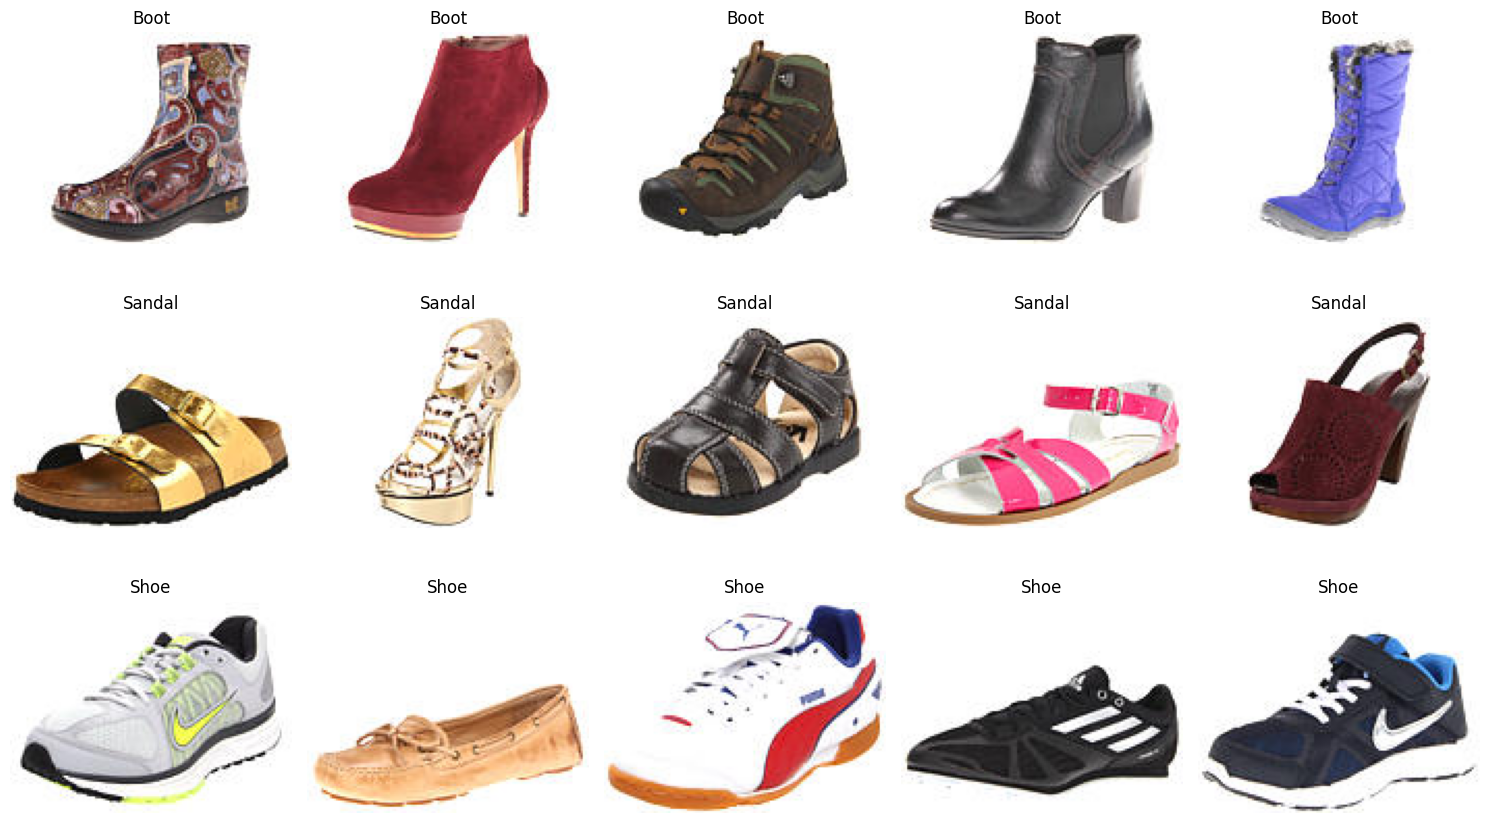

In [ ]:
# Inisialisasi path ke folder dataset
shoes_path = "dataset_new/dataset"

# Cek apakah folder dataset ada. Jika tidak, program dihentikan dengan error.
if not os.path.exists(shoes_path):
    raise FileNotFoundError(f"❌ Folder '{shoes_path}' tidak ditemukan.")

# Membuat dictionary untuk menyimpan daftar nama file gambar berdasarkan kelasnya
shoes_image = {}
# Mengambil dan mengurutkan nama-nama folder (kelas) yang ada di dalam folder dataset
class_names = sorted(os.listdir(shoes_path))

# Iterasi setiap folder kelas
for class_name in class_names:
    class_path = os.path.join(shoes_path, class_name)
    # Hanya proses jika path tersebut adalah folder
    if os.path.isdir(class_path):
        # Simpan daftar nama file gambar untuk kelas ini
        shoes_image[class_name] = os.listdir(class_path)

# Membuat subplot dengan jumlah baris = jumlah kelas, dan 5 kolom (5 gambar per kelas)
fig, axs = plt.subplots(len(shoes_image), 5, figsize=(15, 3 * len(shoes_image)))

# Menampilkan 5 gambar acak untuk setiap kelas
for i, class_name in enumerate(class_names):
    image_files = shoes_image[class_name]

    # Jika jumlah gambar dalam suatu kelas kurang dari 5, izinkan pengambilan ulang (replace=True)
    replace = len(image_files) < 5
    selected_images = np.random.choice(image_files, 5, replace=replace)

    # Menampilkan gambar yang dipilih
    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(shoes_path, class_name, img_name)
        try:
            # Membuka gambar
            img = Image.open(img_path)
            # Menampilkan gambar di subplot
            axs[i, j].imshow(img, cmap='grey')
            axs[i, j].set_title(class_name)
            axs[i, j].axis('off')  # Hilangkan sumbu
        except Exception as e:
            # Jika gambar gagal dibuka, tampilkan pesan error
            print(f"Gagal membuka gambar {img_path}: {e}")

# Atur tata letak agar tidak saling tumpang tindih
plt.tight_layout()
# Tampilkan hasil plot
plt.show()

#### Plot Distribusi

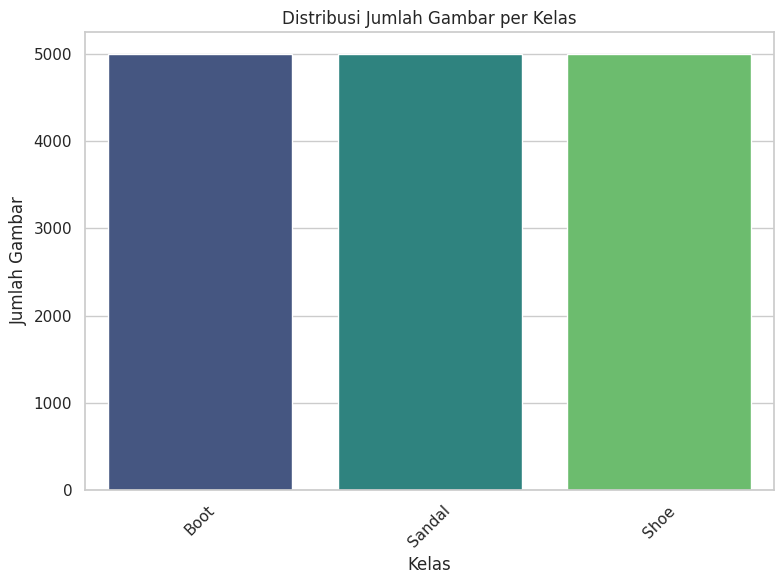

In [ ]:
# Path dataset
shoes_path = "dataset_new/dataset/"

# Inisialisasi list
file_name = []
labels = []
full_path = []

# Loop untuk mendapatkan path, nama file, dan label
for path, subdirs, files in os.walk(shoes_path):
    for name in files:
        if name.lower().endswith((".jpg", ".jpeg", ".png")):  # filter file gambar saja
            full_path.append(os.path.join(path, name))
            labels.append(os.path.basename(path))  # ambil nama folder sebagai label
            file_name.append(name)

# Buat dataframe
distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Plot distribusi jumlah gambar per kelas
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.countplot(data=distribution_train, x="labels", order=distribution_train['labels'].value_counts().index, palette="viridis")
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Data Augmentation

In [ ]:
# Fungsi ini digunakan untuk memastikan format gambar konsisten sebelum diproses lebih lanjut.
# - Mengonversi gambar grayscale ke RGB.
# - Mengubah gambar dengan 4 channel (RGBA) ke 3 channel (RGB).
# - Resize gambar ke ukuran 224x224.
# - Mengubah nilai pixel ke rentang [0,1].
def preprocess_image(img):
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    elif img.shape[2] == 3:
        pass
    img = cv2.resize(img, (224, 224))
    return img_as_float(img)

# Fungsi untuk melakukan augmentasi dengan rotasi acak berlawanan arah jarum jam (0–180 derajat).
def anticlockwise_rotation(img):
    img = preprocess_image(img)
    sudut = random.randint(0, 180)
    return rotate(img, sudut, mode='wrap')

# Fungsi untuk melakukan augmentasi dengan rotasi acak searah jarum jam (0–180 derajat).
def clockwise_rotation(img):
    img = preprocess_image(img)
    sudut = random.randint(0, 180)
    return rotate(img, -sudut, mode='wrap')

# Fungsi untuk melakukan augmentasi dengan membalik gambar secara vertikal (flip atas ke bawah).
def flip_up_down(img):
    img = preprocess_image(img)
    return np.flipud(img)

# Fungsi untuk meningkatkan kecerahan gambar menggunakan metode gamma correction.
# Gamma < 1 akan membuat gambar lebih terang.
def add_brightness(img):
    img = preprocess_image(img)
    return adjust_gamma(img, gamma=0.5, gain=1)

# Fungsi untuk menambahkan efek blur pada gambar menggunakan Gaussian Blur.
def blur_image(img):
    img = preprocess_image(img)
    img = (img * 255).astype(np.uint8)  # Ubah ke 8-bit sebelum blur
    return img_as_float(cv2.GaussianBlur(img, (9, 9), 0))

# Fungsi untuk memberikan efek shearing (kemiringan) secara horizontal pada gambar.
def sheared(img):
    img = preprocess_image(img)
    transform = AffineTransform(shear=0.2)
    return warp(img, transform, mode="wrap")

# Fungsi untuk menggeser gambar secara vertikal sejauh 40 piksel (warp shift).
def warp_shift(img):
    img = preprocess_image(img)
    transform = AffineTransform(translation=(0, 40))
    return warp(img, transform, mode="wrap")

In [ ]:
# Dictionary transformasi augmentasi gambar
# Setiap string merepresentasikan nama transformasi dan dikaitkan dengan fungsi yang akan diterapkan
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'flip up down': flip_up_down,
    'add brightness': add_brightness,
    'blurring image': blur_image,
    'shear image': sheared,
    'warp shift': warp_shift
}

# Direktori asal dataset gambar (sebelum augmentasi)
original_dataset_dir = 'dataset_new/dataset'

# Direktori tujuan untuk menyimpan gambar hasil augmentasi
augmented_dataset_dir = 'dataset_new/augmented_dataset'
os.makedirs(augmented_dataset_dir, exist_ok=True)  # Membuat folder jika belum ada

# Jumlah target gambar hasil augmentasi yang ingin dibuat untuk setiap kelas
images_to_generate = 2000

# Proses augmentasi dimulai untuk setiap label/kategori dalam dataset
for label in os.listdir(original_dataset_dir):
    images_path = os.path.join(original_dataset_dir, label)  # Path folder asli untuk kategori ini
    augmented_path = os.path.join(augmented_dataset_dir, label)  # Path folder hasil augmentasi

    # Membuat folder untuk menyimpan gambar augmentasi jika belum tersedia
    os.makedirs(augmented_path, exist_ok=True)

    # Mengambil semua file gambar pada folder label tertentu
    images = [
        os.path.join(images_path, im)
        for im in os.listdir(images_path)
        if os.path.isfile(os.path.join(images_path, im))
    ]

    print(f"Augmenting label '{label}'...")

    i = 1  # Inisialisasi hitungan gambar augmentasi
    while i <= images_to_generate:
        image_path = random.choice(images)  # Pilih gambar secara acak dari folder label

        try:
            # Membaca gambar asli
            original_image = io.imread(image_path)
            transformed_image = original_image

            # Menentukan berapa banyak transformasi yang akan diterapkan pada gambar
            transformation_count = random.randint(1, len(transformations))
            n = 0

            # Menerapkan transformasi secara acak sesuai jumlah yang ditentukan
            while n < transformation_count:
                key = random.choice(list(transformations))  # Pilih transformasi secara acak
                transformed_image = transformations[key](transformed_image)  # Terapkan transformasi
                n += 1

            # Simpan gambar hasil augmentasi ke folder tujuan
            new_image_path = os.path.join(augmented_path, f"augmented_image_{i}.jpg")
            transformed_image = img_as_ubyte(transformed_image)  # Konversi ke format uint8 agar bisa disimpan
            cv2.imwrite(new_image_path, transformed_image)  # Simpan menggunakan OpenCV
            i += 1  # Tambah hitungan gambar yang berhasil dibuat

        except Exception as e:
            # Tangani error jika gambar tidak bisa dibaca atau diproses
            print(f"Could not read {image_path}: {e} — skipping.")

# Menandai bahwa proses augmentasi seluruh label telah selesai
print("\n✅ Semua augmentasi selesai!")

Augmenting label 'Boot'...
Augmenting label 'Sandal'...
Augmenting label 'Shoe'...

✅ Semua augmentasi selesai!


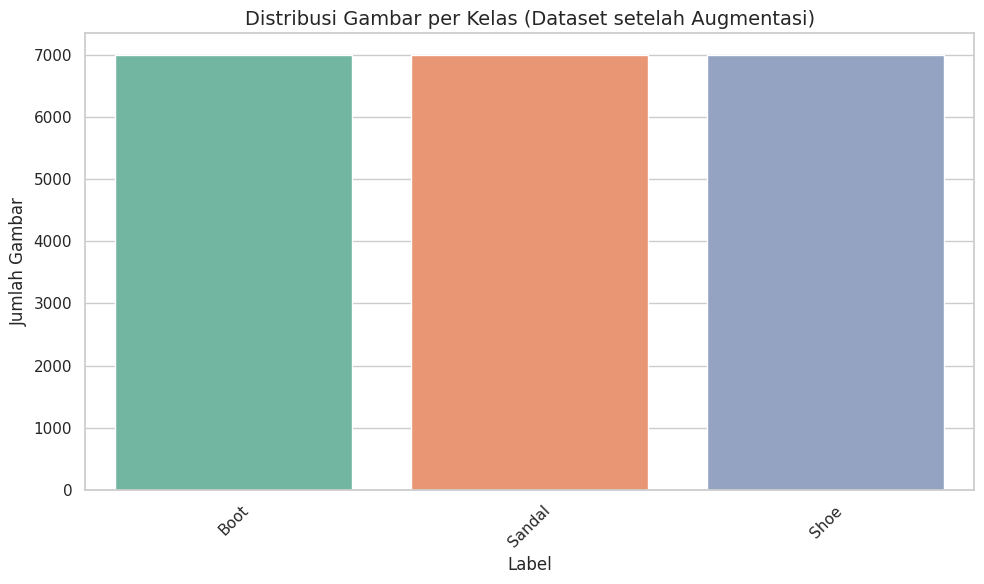

In [ ]:
# Path direktori untuk dataset asli dan dataset hasil augmentasi
shoes_path = "dataset_new/dataset/"
augmented_path = "dataset_new/augmented_dataset/"

# Inisialisasi list untuk menyimpan informasi file
file_name = []  # Nama file gambar
labels = []     # Label/kategori gambar
full_path = []  # Path lengkap ke file gambar

# ✦ Tahap 1: Mengambil data gambar dari direktori asli ✦
# Loop melalui semua folder dan file dalam direktori dataset asli
for path, subdirs, files in os.walk(shoes_path):
    for name in files:
        if name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Hanya ambil file gambar
            full_path.append(os.path.join(path, name))        # Simpan path lengkap gambar
            label = os.path.basename(path)                    # Ambil nama folder sebagai label
            labels.append(label)                              # Simpan label ke list
            file_name.append(name)                            # Simpan nama file gambar

# ✦ Tahap 2: Mengambil data gambar dari direktori hasil augmentasi ✦
# Loop serupa dilakukan untuk gambar-gambar yang sudah diaugmentasi
for path, subdirs, files in os.walk(augmented_path):
    for name in files:
        if name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Hanya ambil file gambar
            full_path.append(os.path.join(path, name))        # Simpan path lengkap gambar
            label = os.path.basename(path)                    # Ambil nama folder sebagai label

            # Jika nama folder label mengandung suffix '_augmented', hapus bagian tersebut
            if label.endswith("_augmented"):
                label = label.replace("_augmented", "")

            labels.append(label)
            file_name.append(name)

# ✦ Tahap 3: Membuat DataFrame yang memuat semua informasi gambar ✦
distribution_df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# ✦ Tahap 4: Visualisasi jumlah gambar per kelas/label ✦
plt.figure(figsize=(10, 6))  # Ukuran plot
sns.set_style("whitegrid")  # Gaya visualisasi seaborn

# Plot distribusi menggunakan countplot
sns.countplot(
    data=distribution_df,
    x='labels',
    order=distribution_df['labels'].value_counts().index,
    palette="Set2"
)

# Tambahkan informasi visual ke plot
plt.title("Distribusi Gambar per Kelas (Dataset setelah Augmentasi)", fontsize=14)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Jumlah Gambar", fontsize=12)
plt.xticks(rotation=45)  # Rotasi label agar lebih mudah dibaca
plt.tight_layout()
plt.show()

#### Data Splitting

In [ ]:
# ✦ Menentukan dua folder utama: folder dataset asli dan folder hasil augmentasi ✦
original_dir  = 'dataset_new/dataset'              # Folder berisi gambar original
augmented_dir = 'dataset_new/augmented_dataset'    # Folder berisi gambar augmentasi

# ✦ Fungsi bantu untuk mengumpulkan gambar dari sebuah folder ✦
def collect_images_from(root):
    paths, labels, names = [], [], []  # Inisialisasi list untuk menyimpan data
    for dirpath, _, files in os.walk(root):        # Telusuri semua file di dalam folder
        for f in files:
            if f.lower().endswith(('.jpg','.jpeg','.png')):  # Hanya file gambar
                paths.append(os.path.join(dirpath, f))       # Simpan path lengkap
                labels.append(os.path.basename(dirpath))     # Label = nama folder tempat gambar berada
                names.append(f)                              # Simpan nama file
    return paths, labels, names

# ✦ Mengumpulkan data dari folder asli dan folder augmentasi ✦
p1, l1, n1 = collect_images_from(original_dir)     # Gambar dan label dari dataset asli
p2, l2, n2 = collect_images_from(augmented_dir)    # Gambar dan label dari dataset augmentasi

# ✦ Membuat DataFrame gabungan dari kedua sumber data ✦
df = pd.DataFrame({
    'path':       p1 + p2,     # Gabungkan semua path gambar
    'file_name':  n1 + n2,     # Gabungkan nama file
    'labels':     l1 + l2      # Gabungkan label
})

# ✦ Tampilkan jumlah gambar per kelas (label) ✦
# Ini penting untuk mengetahui apakah distribusi gambar sudah seimbang setelah augmentasi
print(df['labels'].value_counts(dropna=False))

labels
Boot      7000
Sandal    7000
Shoe      7000
Name: count, dtype: int64


In [ ]:
# ✦ Menentukan variabel input (fitur) dan output (label) ✦
X = df['path']    # X = path ke file gambar (fitur input untuk model)
y = df['labels']  # y = label atau kelas dari masing-masing gambar

# ✦ Split dataset menjadi data training dan data testing ✦
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% dari total data akan digunakan sebagai data uji (test set)
    random_state=300      # Nilai random_state untuk memastikan split selalu sama (reproducible)
)

In [ ]:
# ✦ Membuat DataFrame untuk masing-masing subset (train dan test) ✦
df_tr = pd.DataFrame({
    'path': X_train,     # Path gambar untuk data training
    'labels': y_train,   # Label/kategori gambar training
    'set': 'train'       # Penanda bahwa ini adalah data train
})

df_te = pd.DataFrame({
    'path': X_test,      # Path gambar untuk data testing
    'labels': y_test,    # Label/kategori gambar testing
    'set': 'test'        # Penanda bahwa ini adalah data test
})

In [ ]:
# ✦ Menggabungkan DataFrame train dan test menjadi satu DataFrame ✦
df_all = pd.concat([df_tr, df_te], ignore_index=True)  # ignore_index=True untuk reset index secara otomatis

# ✦ Menampilkan distribusi jumlah gambar per kelas, dipisahkan berdasarkan jenis data (train/test) ✦
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')  # Hitung jumlah gambar per label dalam setiap set
print('===================================================== \n')

# ✦ Menampilkan 5 sampel acak dari data untuk verifikasi struktur dan isi data ✦
print(df_all.sample(5))


set    labels
test   Boot      1363
       Sandal    1458
       Shoe      1379
train  Boot      5637
       Sandal    5542
       Shoe      5621
dtype: int64 


                                               path  labels    set
1548   dataset_new/dataset/Sandal/Sandal (1219).jpg  Sandal  train
16979  dataset_new/dataset/Sandal/Sandal (3283).jpg  Sandal   test
5022       dataset_new/dataset/Boot/boot (2384).jpg    Boot  train
2088       dataset_new/dataset/Shoe/Shoe (2387).jpg    Shoe  train
4625       dataset_new/dataset/Boot/boot (2674).jpg    Boot  train


In [ ]:
# Path ke direktori dataset asli yang berisi gambar-gambar sebelum dibagi
datasource_path = "dataset_new/dataset/"

# Path ke direktori dataset final yang akan digunakan sebagai acuan/pelatihan model
dataset_path = "Dataset-Final/"

In [ ]:
# 📦 Memindahkan file gambar ke dalam struktur folder Dataset-Final/train/label/ dan Dataset-Final/test/label/
for index, row in tq(df_all.iterrows()):
    # 🎯 Ambil path gambar dari DataFrame
    file_path = row['path']

    # 🧭 Cek apakah path gambar masih valid (untuk menghindari error)
    if not os.path.exists(file_path):
        # ❗Jika tidak ditemukan, coba bangun ulang path berdasarkan struktur folder asal
        # Tapi pastikan kolom 'image' ada di DataFrame, kalau tidak, sebaiknya skip
        try:
            rebuilt_file = row['image'] if 'image' in row else os.path.basename(file_path)
            rebuilt_file += '.jpg' if not rebuilt_file.endswith('.jpg') else ''
            file_path = os.path.join(datasource_path, row['labels'], rebuilt_file)
        except Exception as e:
            print(f"❌ Error membangun ulang path pada index {index}: {e}")
            continue  # Skip file ini

    # 📁 Buat folder tujuan jika belum ada: Dataset-Final/train/<label>/ atau test/<label>/
    dest_dir = os.path.join(dataset_path, row['set'], row['labels'])
    os.makedirs(dest_dir, exist_ok=True)

    # 📝 Tentukan nama file akhir dan path tujuan
    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(dest_dir, destination_file_name)

    # 📤 Salin file hanya jika belum ada
    if not os.path.exists(file_dest):
        try:
            shutil.copy2(file_path, file_dest)  # Menyimpan metadata
        except Exception as e:
            print(f"❌ Gagal menyalin {file_path} ke {file_dest}: {e}")

21000it [00:04, 4285.66it/s]


#### Image Data Generator

In [ ]:
# 📁 Definisikan direktori untuk training dan testing dataset
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR  = "Dataset-Final/test/"

# 🏷️ Daftar label/kategori yang ada di dataset
classes = ['Boot', 'Sandal', 'Shoe']

# 🔍 Cek jumlah gambar pada setiap kelas di training set
print("📊 Jumlah gambar di Training Set:")
for class_name in classes:
    class_path = os.path.join(TRAIN_DIR, class_name)
    total_images = len(os.listdir(class_path))
    print(f" - {class_name}: {total_images} gambar")

# 🔍 Cek jumlah gambar pada setiap kelas di test set
print("\n📊 Jumlah gambar di Test Set:")
for class_name in classes:
    class_path = os.path.join(TEST_DIR, class_name)
    total_images = len(os.listdir(class_path))
    print(f" - {class_name}: {total_images} gambar")

📊 Jumlah gambar di Training Set:
 - Boot: 5637 gambar
 - Sandal: 5542 gambar
 - Shoe: 5621 gambar

📊 Jumlah gambar di Test Set:
 - Boot: 1363 gambar
 - Sandal: 1458 gambar
 - Shoe: 1379 gambar


In [ ]:
# ✅ Membuat objek ImageDataGenerator untuk preprocessing gambar
# Gambar dinormalisasi ke rentang [0, 1] dengan membagi nilai piksel 255
datagen = ImageDataGenerator(
    rescale=1./255,              # Normalisasi
    validation_split=0.2         # Memisahkan 20% data training untuk validasi
)

# Untuk test set hanya perlu rescale (tanpa split)
test_datagen = ImageDataGenerator(rescale=1./255)

# 🔁 Data Generator untuk Training
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,                   # Direktori data training
    batch_size=32,               # Jumlah gambar per batch
    target_size=(224, 224),      # Ukuran gambar (disesuaikan dengan arsitektur CNN)
    color_mode="rgb",            # Gambar berwarna RGB
    class_mode='categorical',    # Klasifikasi multi-kelas (output berupa one-hot vector)
    subset='training',           # Ambil data untuk training
    shuffle=True                 # Acak data untuk menghindari pola
)

# 🔁 Data Generator untuk Validation
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',        # Ambil data untuk validasi
    shuffle=False
)

# 🔁 Data Generator untuk Test
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,                # Batch 1 agar bisa evaluasi/analisis per gambar
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

Found 13441 images belonging to 3 classes.
Found 3359 images belonging to 3 classes.
Found 4200 images belonging to 3 classes.


## Modelling

In [ ]:
# Membersihkan sesi sebelumnya (penting saat restart training)
tf.keras.backend.clear_session()

# 🧠 Load dan Konfigurasi MobileNetV2 sebagai base model
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,      # Tidak menyertakan FC layer bawaan
    weights='imagenet'      # Memuat bobot pre-trained dari ImageNet
)

# Mengaktifkan fine-tuning sebagian layer (mulai dari layer ke-100)
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 🔧 Bangun model klasifikasi akhir (custom head)
model_mobilenet = Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(3, activation='softmax')  # Output untuk 3 kelas
])

# ⚙️ Compile dan Setup Callback
model_mobilenet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ⏹️ Callback untuk optimasi training
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

callbacks_list = [earlystop, reduce_lr]

# Training model
history = model_mobilenet.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks_list
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


421/421 ━━━━━━━━━━━━━━━━━━━━ 78s 125ms/step - accuracy: 0.4181 - loss: 2.5665 - val_accuracy: 0.7297 - val_loss: 2.1649 - learning_rate: 1.0000e-05
Epoch 2/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - accuracy: 0.6426 - loss: 2.1186 - val_accuracy: 0.8366 - val_loss: 1.9186 - learning_rate: 1.0000e-05
Epoch 3/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.7502 - loss: 1.9241 - val_accuracy: 0.8631 - val_loss: 1.7493 - learning_rate: 1.0000e-05
Epoch 4/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.8172 - loss: 1.7853 - val_accuracy: 0.8836 - val_loss: 1.6325 - learning_rate: 1.0000e-05
Epoch 5/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - accuracy: 0.8629 - loss: 1.6687 - val_accuracy: 0.8896 - val_loss: 1.5496 - learning_rate: 1.0000e-05
Epoch 6/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.9020 - loss: 1.5683 - val_accuracy: 0.9128 - val_loss: 1.4740 - learning_rate: 1.0000e-05
Epoch 7/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - accura

In [ ]:
# Menghitung jumlah gambar pelatihan untuk setiap kelas
# Dictionary ini menyimpan jumlah file gambar pada masing-masing folder kelas
train_class_counts = {
    'Boot': len(os.listdir(os.path.join(TRAIN_DIR, 'Boot'))),
    'Sandal': len(os.listdir(os.path.join(TRAIN_DIR, 'Sandal'))),
    'Shoe': len(os.listdir(os.path.join(TRAIN_DIR, 'Shoe'))),
}

# Menghitung total gambar dan jumlah kelas
# total_train adalah jumlah semua gambar dari semua kelas
total_train = sum(train_class_counts.values())

# n_classes adalah jumlah total kelas (dalam hal ini: Boot, Sandal, Shoe)
n_classes = len(train_class_counts)

# Menghitung class weights
# Class weights digunakan untuk menangani dataset yang tidak seimbang
# Kelas dengan jumlah data yang lebih sedikit akan memiliki bobot lebih besar
class_weights = {}
for i, (label, count) in enumerate(train_class_counts.items()):
    # Rumus class weight: (1 / jumlah_data_kelas) * (total_data / jumlah_kelas)
    class_weights[i] = (1 / count) * (total_train / n_classes)

print("Class Weights:", class_weights)

# Melatih model dengan class weights
# history_mobilenet menyimpan hasil pelatihan untuk analisis lebih lanjut (misal: plotting accuracy/loss)
history_mobilenet = model_mobilenet.fit(
    train_generator,             # Generator untuk data pelatihan
    epochs=50,                   # Jumlah epoch pelatihan
    batch_size=32,               # Ukuran batch
    validation_data=validation_generator,  # Generator untuk data validasi
    class_weight=class_weights, # Menerapkan class weights untuk menangani ketidakseimbangan kelas
    callbacks=callbacks_list     # Daftar callback (misal: early stopping, checkpoint, dll.)
)

Class Weights: {0: 0.9934362249423452, 1: 1.0104655359076145, 2: 0.9962640099626401}
Epoch 1/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 49s 81ms/step - accuracy: 0.9971 - loss: 0.5632 - val_accuracy: 0.9437 - val_loss: 0.7301 - learning_rate: 1.0000e-05
Epoch 2/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.9979 - loss: 0.5390 - val_accuracy: 0.9414 - val_loss: 0.7239 - learning_rate: 1.0000e-05
Epoch 3/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - accuracy: 0.9979 - loss: 0.5154 - val_accuracy: 0.9464 - val_loss: 0.6890 - learning_rate: 1.0000e-05
Epoch 4/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.9988 - loss: 0.4899 - val_accuracy: 0.9515 - val_loss: 0.6427 - learning_rate: 1.0000e-05
Epoch 5/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.9984 - loss: 0.4705 - val_accuracy: 0.9321 - val_loss: 0.7108 - learning_rate: 1.0000e-05
Epoch 6/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.9982 - loss: 0.4507 - val_accuracy: 0.9372 - val_loss: 0.

## Evaluasi dan Visualisasi

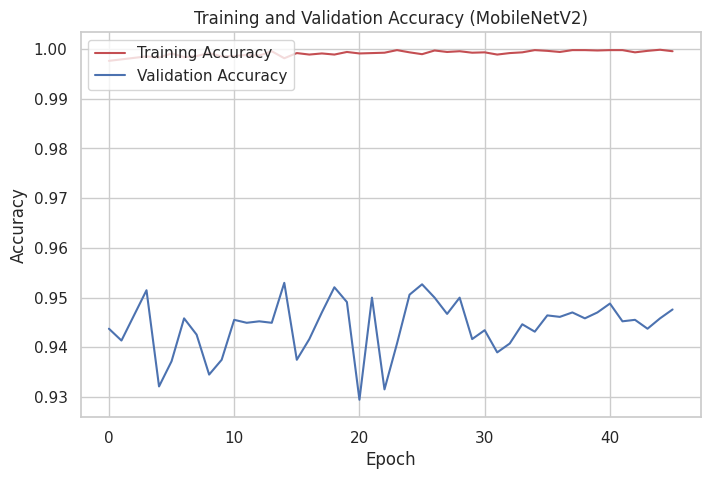

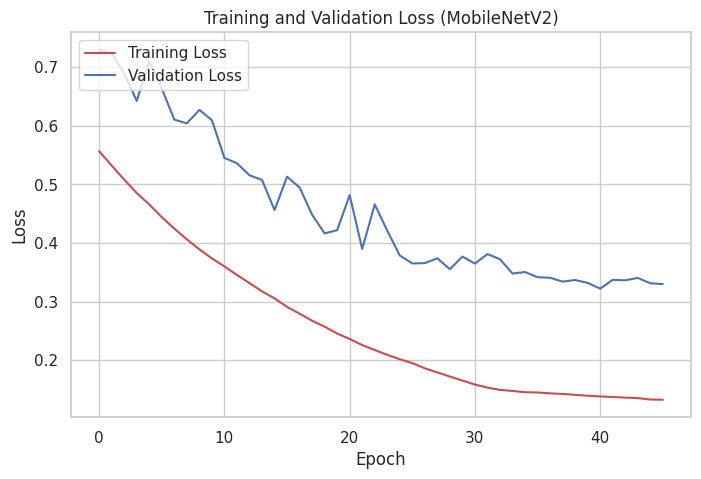

In [ ]:
# Mengambil data akurasi dan loss dari history training
# history.history adalah dictionary yang menyimpan metrik dari setiap epoch selama training
acc = history_mobilenet.history['accuracy']         # Akurasi data pelatihan
val_acc = history_mobilenet.history['val_accuracy'] # Akurasi data validasi
loss = history_mobilenet.history['loss']            # Loss data pelatihan
val_loss = history_mobilenet.history['val_loss']    # Loss data validasi

# Menentukan jumlah epoch
# Digunakan untuk sumbu-x pada grafik
epochs = range(len(acc))

# Plot grafik akurasi pelatihan dan validasi
plt.figure(figsize=(8, 5))  # Ukuran grafik
plt.plot(epochs, acc, 'r', label='Training Accuracy')     # Garis merah: akurasi pelatihan
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy') # Garis biru: akurasi validasi
plt.title('Training and Validation Accuracy (MobileNetV2)') # Judul grafik
plt.xlabel('Epoch')      # Label sumbu-x
plt.ylabel('Accuracy')   # Label sumbu-y
plt.legend(loc='upper left')  # Letak legenda
plt.grid(True)           # Menampilkan grid untuk mempermudah pembacaan
plt.show()

# Plot grafik loss pelatihan dan validasi
plt.figure(figsize=(8, 5))  # Ukuran grafik
plt.plot(epochs, loss, 'r', label='Training Loss')       # Garis merah: loss pelatihan
plt.plot(epochs, val_loss, 'b', label='Validation Loss') # Garis biru: loss validasi
plt.title('Training and Validation Loss (MobileNetV2)')  # Judul grafik
plt.xlabel('Epoch')      # Label sumbu-x
plt.ylabel('Loss')       # Label sumbu-y
plt.legend(loc='upper left')  # Letak legenda
plt.grid(True)           # Menampilkan grid
plt.show()

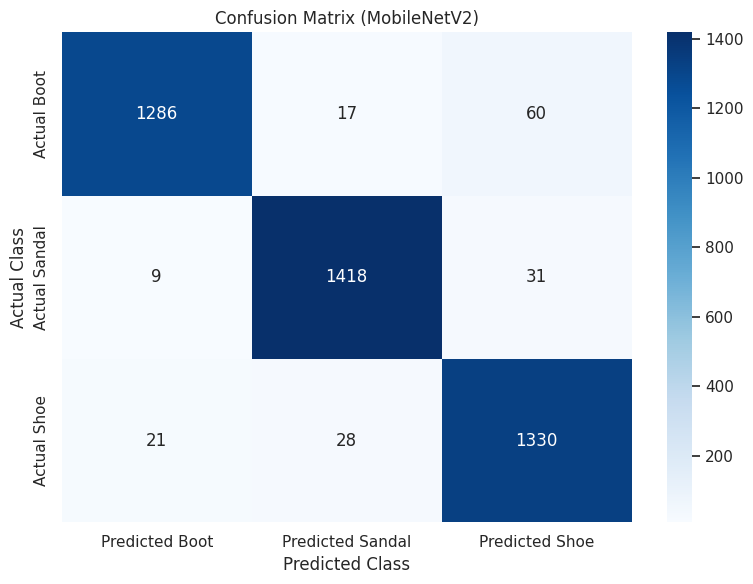


Classification Report (MobileNetV2):

              precision    recall  f1-score   support

        Boot     0.9772    0.9435    0.9601      1363
      Sandal     0.9692    0.9726    0.9709      1458
        Shoe     0.9360    0.9645    0.9500      1379

    accuracy                         0.9605      4200
   macro avg     0.9608    0.9602    0.9603      4200
weighted avg     0.9609    0.9605    0.9605      4200



In [ ]:
# Reset test generator
# Penting untuk menghindari duplikasi data jika test_generator sudah digunakan sebelumnya
test_generator.reset()

# Melakukan prediksi dengan model MobileNetV2
# Hasil prediksi berupa probabilitas untuk setiap kelas
preds_mobilenet = model_mobilenet.predict(test_generator, verbose=0)

# Mengambil label hasil prediksi
# Mengambil indeks kelas dengan probabilitas tertinggi untuk setiap sampel
y_pred = np.argmax(preds_mobilenet, axis=1)

# Mendapatkan label sebenarnya dari test set
# test_generator.classes berisi label ground-truth (dalam bentuk indeks numerik)
y_true = test_generator.classes

# Mendapatkan nama kelas
# class_indices adalah dictionary mapping dari nama kelas ke indeks
# keys-nya diambil sebagai nama label untuk confusion matrix dan classification report
class_labels = list(test_generator.class_indices.keys())

# Membuat Confusion Matrix
cm = pd.DataFrame(
    data=confusion_matrix(y_true, y_pred),
    index=[f"Actual {label}" for label in class_labels],     # Label baris
    columns=[f"Predicted {label}" for label in class_labels] # Label kolom
)

# Visualisasi Confusion Matrix dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  # fmt="d" untuk menampilkan angka integer
plt.title("Confusion Matrix (MobileNetV2)")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()

# Menampilkan Classification Report
# Menyediakan metrik evaluasi: precision, recall, f1-score, dan support untuk setiap kelas
print("\nClassification Report (MobileNetV2):\n")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

## Konversi Model

In [ ]:
# Menyimpan model MobileNetV2
# save_path adalah direktori tempat model akan disimpan
# Format penyimpanan adalah SavedModel (standar format TensorFlow)
save_path = 'mymodel/'

# tf.saved_model.save() menyimpan model dalam format SavedModel
tf.saved_model.save(model_mobilenet, save_path)

In [ ]:
# Menyimpan model dalam format SavedModel
export_dir = 'mymodel/'
tf.saved_model.save(model_mobilenet, export_dir)

# Convert SavedModel menjadi model.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Menyimpan model dalam format TFLite
tflite_model_path = 'model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Class label
class_labels = ['Boot', 'Sandal', 'Shoe']

# Simpan label ke label.txt
with open('label.txt', 'w') as f:
    for label in class_labels:
        f.write(f"{label}\n")

In [ ]:
# Install tensorflowjs
!pip install tensorflowjs

# Convert mymodel to model
!tensorflowjs_converter --input_format=tf_saved_model mymodel/ tfjs_model/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-06-06 16:36:34.411709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749227794.447832   11818 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attem

## Inference (Menggunkakan Tensorflow.js)

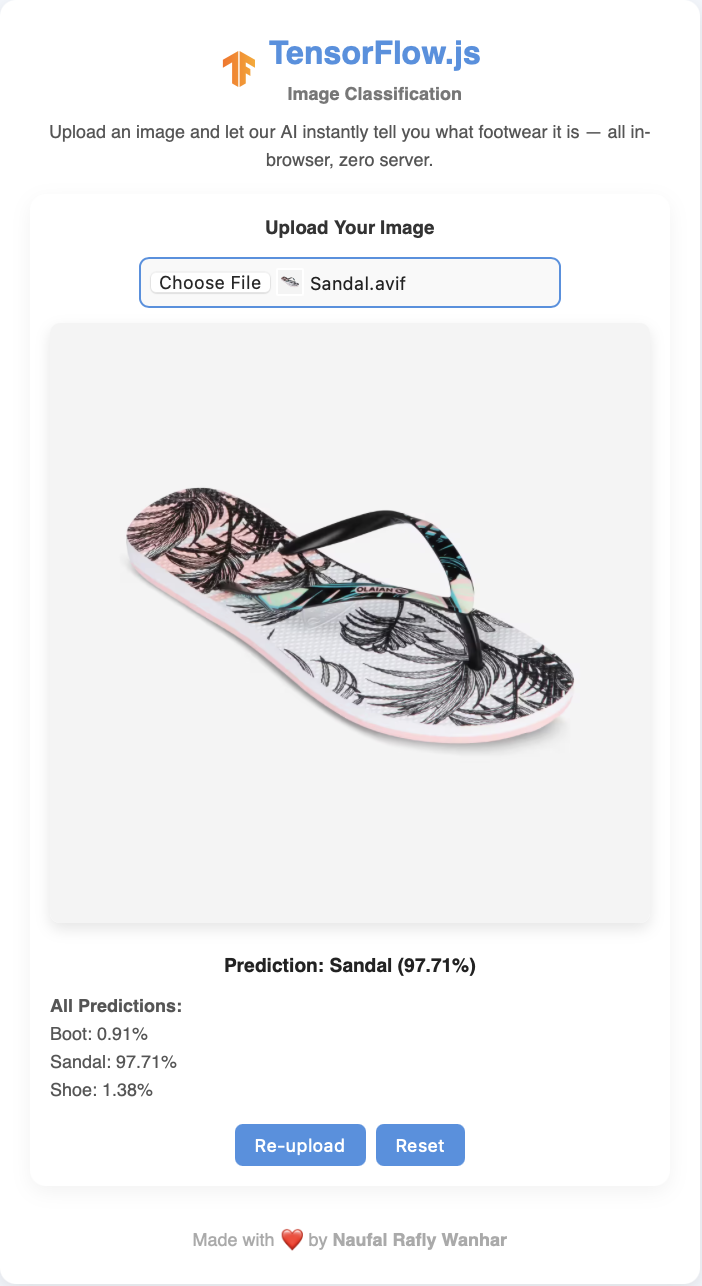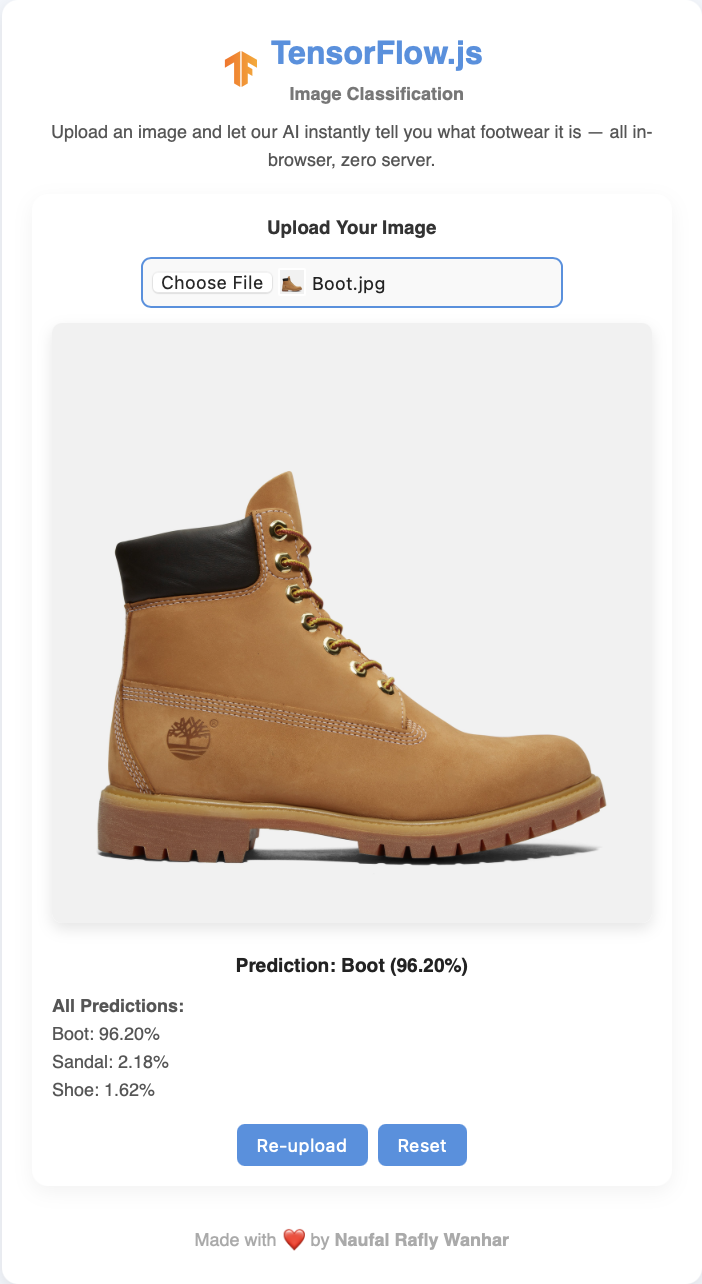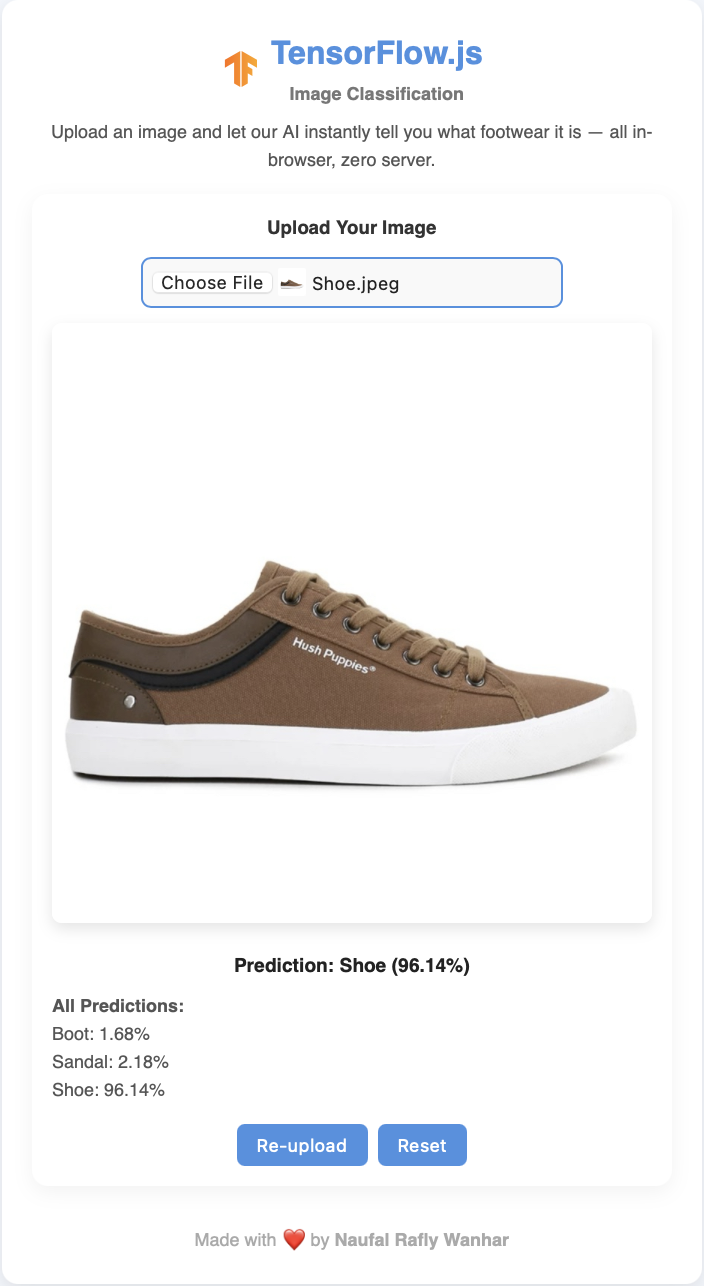

In [ ]:
# Membuat file zip dari direktori model
# Perintah ini membuat file zip bernama `tfjs_model.zip` yang berisi seluruh isi dari folder `tfjs_model`
# Tujuannya adalah untuk memudahkan proses download atau distribusi model

!zip -r tfjs_model.zip tfjs_model

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/model.json (deflated 96%)
  adding: tfjs_model/group1-shard3of3.bin (deflated 8%)
  adding: tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of3.bin (deflated 7%)


In [ ]:
# Membuat file ZIP dari direktori model 'mymodel'
# Perintah ini akan:
# - Mengompresi seluruh isi folder 'mymodel'
# - Menyimpannya dalam file ZIP bernama 'mymodel.zip'
# - Berguna untuk mempermudah proses download atau backup model

!zip -r mymodel.zip mymodel

  adding: mymodel/ (stored 0%)
  adding: mymodel/variables/ (stored 0%)
  adding: mymodel/variables/variables.index (deflated 77%)
  adding: mymodel/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: mymodel/assets/ (stored 0%)
  adding: mymodel/fingerprint.pb (stored 0%)
  adding: mymodel/saved_model.pb (deflated 92%)


In [ ]:
# Menyimpan daftar semua package Python yang terinstal
# Perintah ini mengekspor seluruh dependensi lingkungan saat ini dan menyimpannya ke dalam file `requirements.txt`

!pip freeze > requirements.txt